# Imports

In [1]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U albumentations

  Using cached albumentations-1.4.3-py3-none-any.whl.metadata (37 kB)
Using cached albumentations-1.4.3-py3-none-any.whl (137 kB)
Note: you may need to restart the kernel to use updated packages.


In [88]:
import torch
import cv2
import shutil
import os
import zipfile
import gzip
import random
from pprint import pprint

from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
import torchvision.models as models

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

## Unzipping the dataset

### DONT USE UNTIL PORTING A NEW DATASET

In [ ]:
directory_to_remove = 'data_cloud_final/data_cloud_final/imgs/train_set'

try:
    shutil.rmtree(directory_to_remove)
    print(f"Directory '{directory_to_remove}' successfully removed.")
except OSError as e:
    print(f"Error: {directory_to_remove} : {e.strerror}")

In [ ]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Change the working directory to the parent directory
os.chdir('..')

# Verify the change
new_directory = os.getcwd()
print("New working directory:", new_directory)

In [33]:
# Path to your ZIP file
zip_file = "data_cloud_final.zip"
destination_folder = "data_cloud_final"

try:
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

        # Unzip the contents of the gzip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)

        print("Files unzipped successfully.")
    else:
        print("Destination folder already exists. Skipping extraction.")
except Exception as e:
    print(f"Error: {e}")

Files unzipped successfully.


# Original Data check

In [22]:
imgs = r'data_cloud_final/data_cloud_final/imgs/train'

In [23]:
# Get the list of subfolders in the main directory
subfolders = [f.path for f in os.scandir(imgs) if f.is_dir()]
print(subfolders)

['data_cloud_final/data_cloud_final/imgs/train/YES', 'data_cloud_final/data_cloud_final/imgs/train/NO', 'data_cloud_final/data_cloud_final/imgs/train/.ipynb_checkpoints']


In [24]:
yes_subfolder = subfolders[0]
yes_subfolder

'data_cloud_final/data_cloud_final/imgs/train/YES'

In [25]:
yes_subfolder_subfolder = [f.path for f in os.scandir(yes_subfolder) if f.is_dir()]
yes_subfolder_subfolder

['data_cloud_final/data_cloud_final/imgs/train/YES/c3',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c1',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c6',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c7',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c4',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c5',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c2',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c8',
 'data_cloud_final/data_cloud_final/imgs/train/YES/c9']

In [26]:
no_subfolder=subfolders[1]
no_subfolder

'data_cloud_final/data_cloud_final/imgs/train/NO'

In [27]:
no_subfolder_subfolder = [f.path for f in os.scandir(no_subfolder) if f.is_dir()]
no_subfolder_subfolder

['data_cloud_final/data_cloud_final/imgs/train/NO/c0']

In [28]:
images_yes = []

for subfolder in yes_subfolder_subfolder:
    files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith('.jpg')]
    images_yes.extend(files)

In [29]:
len(images_yes)

2259

In [30]:
image_no=[]

for subfolder in no_subfolder_subfolder:
    files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith('.jpg')]
    image_no.extend(files)

In [31]:
len(image_no)

2259

# Training set creation {Balanced}

In [32]:
def count_jpg_files_in_directory(path):
    # Initialize a counter
    jpg_count = 0

    # Walk through the directory and count JPG files
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith('.jpg'):
                jpg_count += 1

    return jpg_count

In [33]:
# Number of images to pick from each subfolder
num_images_to_train_test = 900

### NO

In [34]:
# Pick the specified number of images
selected_images_train = random.sample(image_no, num_images_to_train_test)

# make destination directory
destination_dir_train = r'training_set/'

# Remove existing directories and create new ones
shutil.rmtree(destination_dir_train, ignore_errors=True)
os.makedirs(destination_dir_train)

for image_path in selected_images_train:
    # Create the destination subfolder structure in the destination directory
    relative_path = os.path.relpath(image_path, imgs)
    relative_path = relative_path.replace("/c0","")
    destination_path = os.path.join(destination_dir_train, relative_path)
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    # Copy the image
    shutil.copyfile(image_path, destination_path)

print(f"{num_images_to_train_test} images from each subfolder have been copied to {destination_dir_train}.")

900 images from each subfolder have been copied to training_set/.


In [35]:
path = r'training_set/NO'
file_count = count_jpg_files_in_directory(path)
print("Number of NO images in directory:", file_count)

Number of NO images in directory: 900


### YES

In [36]:
for folder in yes_subfolder_subfolder:

    images = [f.path for f in os.scandir(folder) if f.is_file() and f.name.endswith(('.jpg'))]
    # print(images[:3])
    # Pick the specified number of images
    selected_images_train = random.sample(images, int(num_images_to_train_test / 9))

    # make destination directory
    destination_dir_train = r'training_set/'

    os.makedirs(destination_dir_train,exist_ok=True)

    for image_path in selected_images_train:
        # Create the destination subfolder structure in the destination directory
        relative_path = os.path.relpath(image_path, imgs)

         # Define the list of 'cX' values to replace
        c_values_to_replace = [f'/c{i}' for i in range(10)]

        # Remove 'cX' values from the relative_path
        for c_value in c_values_to_replace:
            relative_path = relative_path.replace(c_value, '')

        destination_path = os.path.join(destination_dir_train, relative_path)
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        # Copy the image
        shutil.copyfile(image_path, destination_path)

    print(f"{int(num_images_to_train_test / 9)} images from  {folder} have been copied to {destination_dir_train}.")

100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c3 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c1 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c6 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c7 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c4 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c5 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c2 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c8 have been copied to training_set/.
100 images from  data_cloud_final/data_cloud_final/imgs/train/YES/c9 have been copied to training_set/.


In [38]:
path = r'training_set/YES'
file_count = count_jpg_files_in_directory(path)
print("Number of YES images in directory:", file_count)

Number of YES images in directory: 900


# Loading Images

In [4]:
# Define the directory path
directory = 'training_set/'

# Function to recursively find image files in subfolders
def find_images(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file has an image extension
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_files.append(os.path.join(root, file))
    return image_files

# Find all image files in subfolders
all_image_paths = find_images(directory)

In [5]:
all_image_paths_sorted = sorted(all_image_paths)

In [6]:
len(all_image_paths_sorted)

1800

# Import CUDA

In [8]:
# Check if GPU is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # Print information about each GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available. PyTorch is using CPU.")

Number of available GPUs: 1
GPU 0: Tesla T4


# Train / Test {Creation}

In [9]:
train_x = all_image_paths_sorted
train_y = [path.split('/')[-2] for path in all_image_paths_sorted]

In [10]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=5, stratify=train_y)

## Transforms

In [11]:
transforms = A.Compose(
    [
        A.Resize(height=300, width=300), # Resize to 300x300"
        A.ToFloat(),
        ToTensorV2(),
    ]
)

In [12]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
encoded_labels_train = label_encoder.fit_transform(train_y)
tensor_encoded_labels_train = torch.tensor(encoded_labels_train)
pprint(tensor_encoded_labels_train)


# Fit label encoder and transform labels
encoded_labels_test = label_encoder.fit_transform(test_y)
tensor_encoded_labels_test = torch.tensor(encoded_labels_test)
pprint(tensor_encoded_labels_test)

tensor([0, 0, 1,  ..., 0, 0, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       

# Image Dataset Class

In [13]:
class image_Dataset(Dataset):
    def __init__(self, image_paths, tensor_encoded_labels, transform=None):
        """
        Args:
            image_paths (list): List of file paths to images.
            labels (list): List of labels corresponding to the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_paths = image_paths
        self.labels = tensor_encoded_labels
        self.transform = transform


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None and callable(self.transform):
            image = self.transform(image=image)["image"]

        # Convert label to PyTorch tensor
        label = self.labels[idx]

        return image, label

## Dataset check

In [14]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = image_Dataset(train_x,tensor_encoded_labels_train,transforms)
test_dataset = image_Dataset(test_x,tensor_encoded_labels_test,transforms)

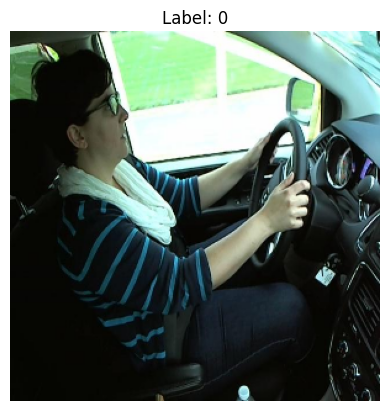

The shape of tensor for 50th image in train dataset:  torch.Size([3, 300, 300])
The label for 50th image in train dataset:  tensor(0)


In [15]:
for i in range(1):
  image, label = train_dataset[i]
  image = TF.to_pil_image(image)  # Convert the tensor to a PIL Image
  image = np.array(image)
  plt.imshow(image)
  plt.title(f"Label: {label}")
  plt.axis('off')  # Turn off axis
  plt.show()

print('The shape of tensor for 50th image in train dataset: ',train_dataset[0][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[0][1])

In [16]:
#######################################################
#                  load Dataset
#######################################################

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Different Model Architectures Training

## Architecture-1

In [24]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ImageClassifier, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(3))
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*33*33, out_features=num_classes))

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)
        return x

### Version 1

#### V1.0

In [52]:
modelV1_0 = ImageClassifier()
modelV1_0.cuda()
modelV1_0.train()

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=139392, out_features=2, bias=True)
  )
)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV1_0.parameters(), lr=0.001, momentum=0.75)
num_epochs = 20

In [54]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV1_0(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 7.9078
Epoch [2/20], Loss: 1.0761
Epoch [3/20], Loss: 1.7510
Epoch [4/20], Loss: 0.5155
Epoch [5/20], Loss: 0.0493
Epoch [6/20], Loss: 0.0195
Epoch [7/20], Loss: 0.0011
Epoch [8/20], Loss: 0.0006
Epoch [9/20], Loss: 0.0001
Epoch [10/20], Loss: 0.0000
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0000
Epoch [14/20], Loss: 0.0000
Epoch [15/20], Loss: 0.0000
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


In [55]:
torch.save(modelV1_0, 'modelV1_0.pth')

#### V1.1

In [56]:
modelV1_1 = ImageClassifier()
modelV1_1 = modelV1_1.to('cuda')
modelV1_1.train()

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=139392, out_features=2, bias=True)
  )
)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV1_1.parameters(), lr=0.0001, momentum=0.50)
num_epochs = 20

In [58]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV1_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 1.2609
Epoch [2/20], Loss: 0.3261
Epoch [3/20], Loss: 0.1339
Epoch [4/20], Loss: 0.1013
Epoch [5/20], Loss: 0.0552
Epoch [6/20], Loss: 0.0393
Epoch [7/20], Loss: 0.0317
Epoch [8/20], Loss: 0.0271
Epoch [9/20], Loss: 0.0238
Epoch [10/20], Loss: 0.0213
Epoch [11/20], Loss: 0.0192
Epoch [12/20], Loss: 0.0176
Epoch [13/20], Loss: 0.0163
Epoch [14/20], Loss: 0.0152
Epoch [15/20], Loss: 0.0142
Epoch [16/20], Loss: 0.0134
Epoch [17/20], Loss: 0.0127
Epoch [18/20], Loss: 0.0121
Epoch [19/20], Loss: 0.0115
Epoch [20/20], Loss: 0.0110


In [59]:
torch.save(modelV1_1, 'modelV1_1.pth')

#### V1.2

In [60]:
modelV1_2 = ImageClassifier()
modelV1_2 = modelV1_2.to('cuda')
modelV1_2.train()

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=139392, out_features=2, bias=True)
  )
)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelV1_2.parameters(), lr=0.0001)
num_epochs = 20

In [62]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV1_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 2.0248
Epoch [2/20], Loss: 0.2243
Epoch [3/20], Loss: 0.0764
Epoch [4/20], Loss: 0.0348
Epoch [5/20], Loss: 0.0184
Epoch [6/20], Loss: 0.0088
Epoch [7/20], Loss: 0.0052
Epoch [8/20], Loss: 0.0038
Epoch [9/20], Loss: 0.0028
Epoch [10/20], Loss: 0.0021
Epoch [11/20], Loss: 0.0019
Epoch [12/20], Loss: 0.0018
Epoch [13/20], Loss: 0.0016
Epoch [14/20], Loss: 0.0015
Epoch [15/20], Loss: 0.0014
Epoch [16/20], Loss: 0.0013
Epoch [17/20], Loss: 0.0013
Epoch [18/20], Loss: 0.0012
Epoch [19/20], Loss: 0.0011
Epoch [20/20], Loss: 0.0011


In [63]:
torch.save(modelV1_2, 'modelV1_2.pth')

## Architecture-2

In [25]:
class ImageClassifier_V2(nn.Module):
    def __init__(self, num_classes=2):
        super(ImageClassifier_V2, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2),  # Adjusted kernel_size
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=3, stride=1))  # Adjusted kernel_size and stride

        # Calculate the input size for the linear layer based on the output of conv_layer_3
        self.classifier_input_size = 512*34*34  # Adjusted based on the spatial dimensions

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.classifier_input_size, out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        #print("Shape after conv_layer_1:", x.shape)

        x = self.conv_layer_2(x)

        #print("Shape after conv_layer_2:", x.shape)
        x = self.conv_layer_3(x)

        #print("Shape after conv_layer_3:", x.shape)


        x = self.classifier(x)
        return x

### Version 2

#### V2.0

In [24]:
torch.cuda.empty_cache()

In [67]:
torch.cuda.memory_summary(device=None, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  73814 KiB |   4910 MiB |  18868 GiB |  18868 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  73814 KiB |   4910 MiB |  18868 GiB |  18868 GiB |\n|---------------------------------------------------------------------------|\n| Requested memory      |  71958 KiB |   4909 MiB |  18866 GiB |  18866 GiB |\n|--------------------------------------------------

In [68]:
modelV2_0 = ImageClassifier_V2()
modelV2_0 = modelV2_0.to('cuda')
modelV2_0.train()

ImageClassifier_V2(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): 

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV2_0.parameters(), lr=0.005, momentum=0.03)
num_epochs = 20

In [70]:
# Assuming you have a DataLoader named 'train_loader'
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV2_0(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)

    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 548.7681
Epoch [2/20], Loss: 200.1508
Epoch [3/20], Loss: 76.6271
Epoch [4/20], Loss: 48.4247
Epoch [5/20], Loss: 29.3480
Epoch [6/20], Loss: 19.6634
Epoch [7/20], Loss: 24.5027
Epoch [8/20], Loss: 11.8800
Epoch [9/20], Loss: 5.0428
Epoch [10/20], Loss: 5.9622
Epoch [11/20], Loss: 4.4721
Epoch [12/20], Loss: 2.5547
Epoch [13/20], Loss: 2.5249
Epoch [14/20], Loss: 23.8425
Epoch [15/20], Loss: 2.8775
Epoch [16/20], Loss: 2.0994
Epoch [17/20], Loss: 1.4300
Epoch [18/20], Loss: 1.2479
Epoch [19/20], Loss: 0.7647
Epoch [20/20], Loss: 0.4781


In [75]:
torch.save(modelV2_0, 'modelV2_0.pth')

#### V2.1

In [71]:
modelV2_1 = ImageClassifier_V2()
modelV2_1 = modelV2_1.to('cuda')
modelV2_1.train()

ImageClassifier_V2(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): 

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelV2_1.parameters(), lr=0.0001)
num_epochs = 20

In [73]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels  = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = modelV2_1(inputs)
        loss1 = criterion(outputs, labels)
        loss1.backward()
        optimizer.step()
        total_loss += (loss1.item())*inputs.size(0)


    average_loss = total_loss / len(train_loader.sampler)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/20], Loss: 8.3365
Epoch [2/20], Loss: 1.3942
Epoch [3/20], Loss: 0.2351
Epoch [4/20], Loss: 0.0691
Epoch [5/20], Loss: 0.1152
Epoch [6/20], Loss: 0.1939
Epoch [7/20], Loss: 0.0586
Epoch [8/20], Loss: 0.0235
Epoch [9/20], Loss: 0.0033
Epoch [10/20], Loss: 0.0131
Epoch [11/20], Loss: 0.0194
Epoch [12/20], Loss: 0.0010
Epoch [13/20], Loss: 0.0021
Epoch [14/20], Loss: 0.0005
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


In [74]:
torch.save(modelV2_1, 'modelV2_1.pth')

# Basic Evaluation

In [18]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
            accuracy = float(num_correct) / float(num_samples) * 100

    return accuracy , num_correct , num_samples

## Architecture - 1

### modelV1_0

In [45]:
modelV1_0 = torch.load("modelV1_0.pth").to('cuda')

In [29]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_0)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_0)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 97.22%, Correct: 350, Total: 360


### modelV1_1

In [ ]:
modelV1_1 = torch.load("modelV1_1.pth").to('cuda')

In [30]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_1)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_1)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 98.06%, Correct: 353, Total: 360


### modelV1_2

In [ ]:
modelV1_2 = torch.load("modelV1_2.pth").to('cuda')

In [31]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_2)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_2)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 98.33%, Correct: 354, Total: 360


##  Architecture - 2

### modelV2_0

In [32]:
modelV2_0 = torch.load("modelV2_0.pth").to('cuda')
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV2_0)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV2_0)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 98.75%, Correct: 1422, Total: 1440
Test Set Accuracy: 91.67%, Correct: 330, Total: 360


### modelV2_1

In [33]:
modelV2_1 = torch.load("modelV2_1.pth").to('cuda')
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV2_1)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV2_1)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 99.17%, Correct: 357, Total: 360


# Loss and train loss graph

In [57]:
def get_loss(model, train_loader, test_loader, optimizer, criterion, num_epochs):
    train_losses = []  # Store train losses
    test_losses = []   # Store test losses

    
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        average_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(average_train_loss)

        # Evaluate on test set
        test_loss = 0.0
        with torch.no_grad():
            model.eval()
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

        average_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(average_test_loss)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Test Loss: {average_test_loss:.4f}')

    return train_losses, test_losses

## Architecture_1

### V1.0

In [79]:
modelV1_0 = ImageClassifier()
modelV1_0.cuda()
modelV1_0.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV1_0.parameters(), lr=0.001, momentum=0.75)
num_epochs = 20

train_losses, test_losses = get_loss(modelV1_0,train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/20], Train Loss: 10.1849, Test Loss: 2.3221
Epoch [2/20], Train Loss: 2.8590, Test Loss: 1.0386
Epoch [3/20], Train Loss: 0.5129, Test Loss: 2.4251
Epoch [4/20], Train Loss: 0.3278, Test Loss: 0.7227
Epoch [5/20], Train Loss: 0.1816, Test Loss: 0.6382
Epoch [6/20], Train Loss: 0.1883, Test Loss: 0.5980
Epoch [7/20], Train Loss: 0.0461, Test Loss: 0.4956
Epoch [8/20], Train Loss: 0.0074, Test Loss: 0.5302
Epoch [9/20], Train Loss: 0.0141, Test Loss: 0.5249
Epoch [10/20], Train Loss: 0.0017, Test Loss: 0.4647
Epoch [11/20], Train Loss: 0.0000, Test Loss: 0.4049
Epoch [12/20], Train Loss: 0.0000, Test Loss: 0.4048
Epoch [13/20], Train Loss: 0.0000, Test Loss: 0.4052
Epoch [14/20], Train Loss: 0.0000, Test Loss: 0.4055
Epoch [15/20], Train Loss: 0.0000, Test Loss: 0.4058
Epoch [16/20], Train Loss: 0.0000, Test Loss: 0.4061
Epoch [17/20], Train Loss: 0.0000, Test Loss: 0.4063
Epoch [18/20], Train Loss: 0.0000, Test Loss: 0.4065
Epoch [19/20], Train Loss: 0.0000, Test Loss: 0.4067
E

In [80]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_0)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_0)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 98.33%, Correct: 354, Total: 360


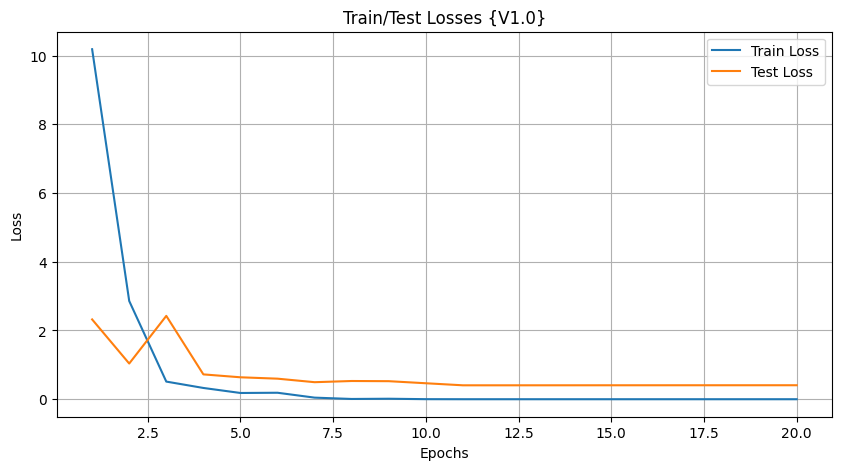

In [81]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Losses {V1.0}')
plt.legend()
plt.grid(True)
plt.savefig('Losses{V1_0}.png')
plt.show()

###  V1.1

In [65]:
modelV1_1 = ImageClassifier()
modelV1_1 = modelV1_1.to('cuda')
modelV1_1.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV1_1.parameters(), lr=0.0001, momentum=0.50)
num_epochs = 20

train_losses, test_losses = get_loss(modelV1_1,train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/20], Train Loss: 1.0991, Test Loss: 0.7780
Epoch [2/20], Train Loss: 0.2201, Test Loss: 0.5283
Epoch [3/20], Train Loss: 0.1198, Test Loss: 0.2642
Epoch [4/20], Train Loss: 0.0880, Test Loss: 0.1698
Epoch [5/20], Train Loss: 0.0634, Test Loss: 0.1554
Epoch [6/20], Train Loss: 0.0485, Test Loss: 0.1448
Epoch [7/20], Train Loss: 0.0381, Test Loss: 0.1251
Epoch [8/20], Train Loss: 0.0318, Test Loss: 0.1126
Epoch [9/20], Train Loss: 0.0276, Test Loss: 0.1062
Epoch [10/20], Train Loss: 0.0245, Test Loss: 0.1024
Epoch [11/20], Train Loss: 0.0222, Test Loss: 0.0996
Epoch [12/20], Train Loss: 0.0203, Test Loss: 0.0975
Epoch [13/20], Train Loss: 0.0188, Test Loss: 0.0957
Epoch [14/20], Train Loss: 0.0174, Test Loss: 0.0942
Epoch [15/20], Train Loss: 0.0163, Test Loss: 0.0930
Epoch [16/20], Train Loss: 0.0153, Test Loss: 0.0919
Epoch [17/20], Train Loss: 0.0145, Test Loss: 0.0910
Epoch [18/20], Train Loss: 0.0137, Test Loss: 0.0902
Epoch [19/20], Train Loss: 0.0130, Test Loss: 0.0895
Ep

In [66]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_1)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_1)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 97.78%, Correct: 352, Total: 360


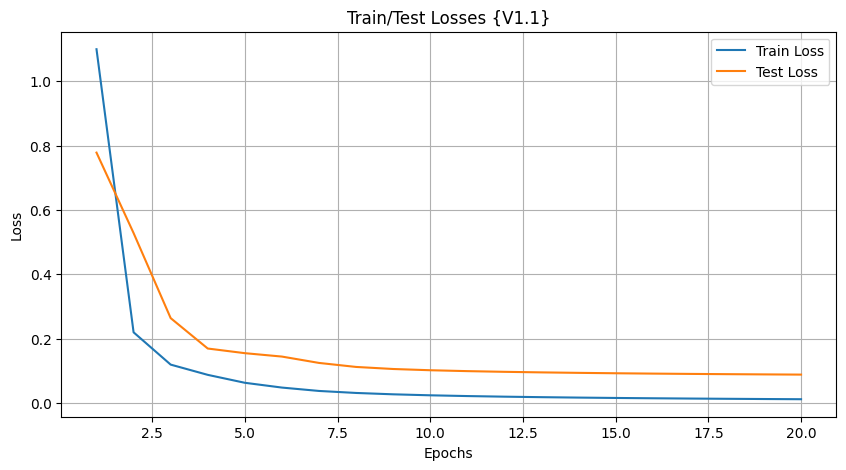

In [68]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Losses {V1.1}')
plt.legend()
plt.grid(True)
plt.savefig('Losses{V1_1}.png')
plt.show()

###  V1.2

In [69]:
modelV1_2 = ImageClassifier()
modelV1_2 = modelV1_2.to('cuda')
modelV1_2.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelV1_2.parameters(), lr=0.0001)
num_epochs = 20

train_losses, test_losses = get_loss(modelV1_2,train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/20], Train Loss: 1.8293, Test Loss: 0.7290
Epoch [2/20], Train Loss: 0.1699, Test Loss: 0.6624
Epoch [3/20], Train Loss: 0.0685, Test Loss: 0.2075
Epoch [4/20], Train Loss: 0.0504, Test Loss: 0.2087
Epoch [5/20], Train Loss: 0.0636, Test Loss: 0.1214
Epoch [6/20], Train Loss: 0.0784, Test Loss: 0.1589
Epoch [7/20], Train Loss: 0.0399, Test Loss: 0.0981
Epoch [8/20], Train Loss: 0.0070, Test Loss: 0.1011
Epoch [9/20], Train Loss: 0.0021, Test Loss: 0.0938
Epoch [10/20], Train Loss: 0.0012, Test Loss: 0.0914
Epoch [11/20], Train Loss: 0.0008, Test Loss: 0.0883
Epoch [12/20], Train Loss: 0.0007, Test Loss: 0.0880
Epoch [13/20], Train Loss: 0.0007, Test Loss: 0.0878
Epoch [14/20], Train Loss: 0.0006, Test Loss: 0.0875
Epoch [15/20], Train Loss: 0.0006, Test Loss: 0.0873
Epoch [16/20], Train Loss: 0.0006, Test Loss: 0.0871
Epoch [17/20], Train Loss: 0.0005, Test Loss: 0.0870
Epoch [18/20], Train Loss: 0.0005, Test Loss: 0.0868
Epoch [19/20], Train Loss: 0.0005, Test Loss: 0.0867
Ep

In [70]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV1_2)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV1_2)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 100.00%, Correct: 1440, Total: 1440
Test Set Accuracy: 98.61%, Correct: 355, Total: 360


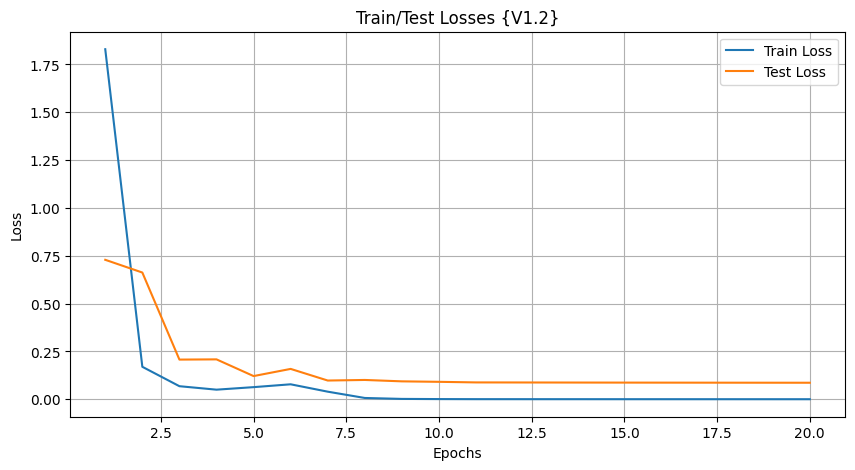

In [71]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Losses {V1.2}')
plt.legend()
plt.grid(True)
plt.savefig('Losses{V1_2}.png')
plt.show()

## Architecture_2

### V2.0

In [73]:
modelV2_0 = ImageClassifier_V2()
modelV2_0 = modelV2_0.to('cuda')
modelV2_0.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV2_0.parameters(), lr=0.005, momentum=0.03)
num_epochs = 20

In [74]:
train_losses, test_losses = get_loss(modelV2_0,train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/20], Train Loss: 463.4915, Test Loss: 233.5156
Epoch [2/20], Train Loss: 256.1009, Test Loss: 104.8177
Epoch [3/20], Train Loss: 69.1352, Test Loss: 35.0461
Epoch [4/20], Train Loss: 48.5356, Test Loss: 24.2186
Epoch [5/20], Train Loss: 35.4914, Test Loss: 38.2687
Epoch [6/20], Train Loss: 30.3113, Test Loss: 26.2992
Epoch [7/20], Train Loss: 18.0830, Test Loss: 22.1242
Epoch [8/20], Train Loss: 9.5220, Test Loss: 12.1926
Epoch [9/20], Train Loss: 9.1815, Test Loss: 18.7095
Epoch [10/20], Train Loss: 8.0152, Test Loss: 10.2065
Epoch [11/20], Train Loss: 3.0965, Test Loss: 10.1025
Epoch [12/20], Train Loss: 2.4586, Test Loss: 9.2473
Epoch [13/20], Train Loss: 1.2941, Test Loss: 7.9803
Epoch [14/20], Train Loss: 1.1116, Test Loss: 7.0741
Epoch [15/20], Train Loss: 1.1701, Test Loss: 6.9138
Epoch [16/20], Train Loss: 4.0753, Test Loss: 8.0031
Epoch [17/20], Train Loss: 1.8823, Test Loss: 25.3902
Epoch [18/20], Train Loss: 2.9987, Test Loss: 8.7530
Epoch [19/20], Train Loss: 0.663

In [86]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV2_0)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV2_0)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 98.82%, Correct: 1423, Total: 1440
Test Set Accuracy: 91.94%, Correct: 331, Total: 360


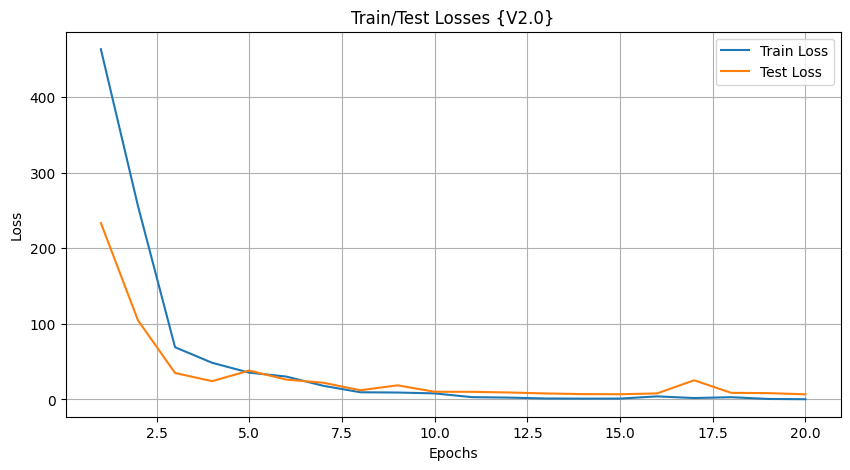

In [75]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Losses {V2.0}')
plt.legend()
plt.grid(True)
plt.savefig('Losses{V2_0}.png')
plt.show()

### V2.1

In [76]:
modelV2_1 = ImageClassifier_V2()
modelV2_1 = modelV2_1.to('cuda')
modelV2_1.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelV2_1.parameters(), lr=0.0001)
num_epochs = 20

In [77]:
train_losses, test_losses = get_loss(modelV2_1,train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/20], Train Loss: 22.6241, Test Loss: 10.0473
Epoch [2/20], Train Loss: 3.8906, Test Loss: 15.9250
Epoch [3/20], Train Loss: 0.6060, Test Loss: 6.1064
Epoch [4/20], Train Loss: 0.2374, Test Loss: 0.7776
Epoch [5/20], Train Loss: 0.1828, Test Loss: 0.5082
Epoch [6/20], Train Loss: 0.1320, Test Loss: 0.9129
Epoch [7/20], Train Loss: 0.1672, Test Loss: 1.8946
Epoch [8/20], Train Loss: 0.1343, Test Loss: 1.0144
Epoch [9/20], Train Loss: 0.3543, Test Loss: 0.7724
Epoch [10/20], Train Loss: 0.1512, Test Loss: 2.5815
Epoch [11/20], Train Loss: 0.3254, Test Loss: 1.2161
Epoch [12/20], Train Loss: 0.3192, Test Loss: 2.6177
Epoch [13/20], Train Loss: 0.3562, Test Loss: 1.3169
Epoch [14/20], Train Loss: 0.6239, Test Loss: 0.8542
Epoch [15/20], Train Loss: 0.7304, Test Loss: 0.7760
Epoch [16/20], Train Loss: 0.5920, Test Loss: 2.5812
Epoch [17/20], Train Loss: 0.9024, Test Loss: 1.9277
Epoch [18/20], Train Loss: 0.4694, Test Loss: 0.9729
Epoch [19/20], Train Loss: 0.1487, Test Loss: 0.7368

In [84]:
train_accuracy, train_correct, train_total = check_accuracy(train_loader, modelV2_1)
test_accuracy, test_correct, test_total = check_accuracy(test_loader, modelV2_1)

print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")

Train Set Accuracy: 99.86%, Correct: 1438, Total: 1440
Test Set Accuracy: 96.11%, Correct: 346, Total: 360


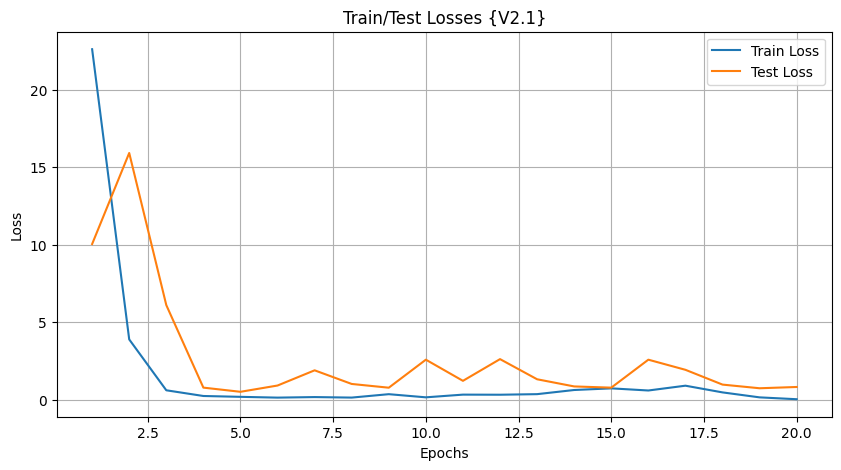

In [78]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Losses {V2.1}')
plt.legend()
plt.grid(True)
plt.savefig('Losses{V2_1}.png')
plt.show()

# CROSS VALIDATION TEST

In [89]:
# Save train_loader
with open('train_loader.pkl', 'wb') as f:
    pickle.dump(train_loader, f)

# Save test_loader
with open('test_loader.pkl', 'wb') as f:
    pickle.dump(test_loader, f)
    
# Save train_dataset
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

# Save test_dataset
with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)

In [ ]:
def train_test(model, device, train_loader, test_loader,optimizer,criterion, num_epochs):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels  = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += (loss.item())*inputs.size(0)
        
    
        average_loss = total_loss / len(train_loader.sampler)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')
        
    model.eval()
        
    train_accuracy, train_correct, train_total = check_accuracy(train_loader, model)
    test_accuracy, test_correct, test_total = check_accuracy(test_loader, model)

    print(f"Train Set Accuracy: {train_accuracy:.2f}%, Correct: {train_correct}, Total: {train_total}")
    print(f"Test Set Accuracy: {test_accuracy:.2f}%, Correct: {test_correct}, Total: {test_total}")    
    
    return train_accuracy, test_accuracy

### validation / test / train split for Kfold

In [13]:
yes_image_paths = [path for path in all_image_paths_sorted if 'YES' in path]
no_image_paths = [path for path in all_image_paths_sorted if 'NO' in path]

# Randomly select 50 YES and 50 NO image paths
selected_yes_image_paths = random.sample(yes_image_paths, 50)
selected_no_image_paths = random.sample(no_image_paths, 50)

# Create validation set containing selected image paths
validation_set = selected_yes_image_paths + selected_no_image_paths

In [14]:
validation_X = validation_set

In [15]:
validation_Y = [path.split('/')[-2] for path in validation_X]

In [16]:
label_encoder = LabelEncoder()
encoded_labels_validation_dataset = label_encoder.fit_transform(validation_Y)
tensor_encoded_labels_validation_dataset = torch.tensor(encoded_labels_validation_dataset)
pprint(tensor_encoded_labels_validation_dataset)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


In [17]:
validation_dataset = image_Dataset(validation_X,tensor_encoded_labels_validation_dataset,transforms)

In [18]:
validation_dataset[0]

(tensor([[[0.0353, 0.0314, 0.0275,  ..., 0.9098, 0.9255, 0.9255],
          [0.0353, 0.0314, 0.0314,  ..., 0.9098, 0.9255, 0.9255],
          [0.0314, 0.0314, 0.0314,  ..., 0.9176, 0.9294, 0.9255],
          ...,
          [0.2863, 0.3451, 0.3686,  ..., 0.0471, 0.0431, 0.0471],
          [0.0157, 0.0510, 0.0471,  ..., 0.0392, 0.0510, 0.0627],
          [0.1059, 0.0824, 0.0863,  ..., 0.0431, 0.0510, 0.0588]],
 
         [[0.0353, 0.0314, 0.0275,  ..., 1.0000, 1.0000, 1.0000],
          [0.0353, 0.0314, 0.0314,  ..., 1.0000, 0.9961, 1.0000],
          [0.0314, 0.0314, 0.0314,  ..., 1.0000, 0.9961, 1.0000],
          ...,
          [0.3686, 0.4275, 0.4510,  ..., 0.0314, 0.0275, 0.0314],
          [0.0980, 0.1333, 0.1294,  ..., 0.0235, 0.0353, 0.0471],
          [0.1882, 0.1647, 0.1647,  ..., 0.0275, 0.0353, 0.0431]],
 
         [[0.0275, 0.0235, 0.0196,  ..., 1.0000, 1.0000, 0.9961],
          [0.0275, 0.0235, 0.0235,  ..., 1.0000, 0.9961, 0.9961],
          [0.0235, 0.0235, 0.0235,  ...,

In [19]:
train_set = [path for path in all_image_paths_sorted if path not in validation_set]

In [20]:
X = train_set
Y = [path.split('/')[-2] for path in train_set]

In [21]:
dataset = list(zip(X, Y))

In [22]:
dataset[0]

('training_set/NO/img_16990.jpg', 'NO')

In [23]:
encoded_labels_Kfold_dataset = label_encoder.fit_transform(Y)
tensor_encoded_labels_Kfold_dataset = torch.tensor(encoded_labels_Kfold_dataset)
pprint(tensor_encoded_labels_Kfold_dataset)

tensor([0, 0, 0,  ..., 1, 1, 1])


In [24]:
#######################################################
#                  Create Dataset
#######################################################

cross_dataset = image_Dataset(X,tensor_encoded_labels_Kfold_dataset,transforms)

In [25]:
validation_loader = DataLoader(dataset=validation_dataset, batch_size=64)

In [26]:
# Define the number of folds and batch size
k_folds = 10
batch_size = 64

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

## Cross validation of Version 1

### Cross validation of V1.0

In [71]:
train_accuracies_V1_0 = []
test_accuracies_V1_0 = []

In [72]:
for fold, (train_idx, test_idx) in enumerate(kf.split(cross_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")
    
    epoch  = 20
    
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=128,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=128,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model = ImageClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

    # Train the model on the current fold
    train_accuracy,test_accuracy = train_test(model, device, train_loader,test_loader, optimizer,criterion, epoch)
        
    # Append accuracies to lists
    train_accuracies_V1_0.append(train_accuracy)
    test_accuracies_V1_0.append(test_accuracy)

Fold 1
-------
Epoch [1/20], Loss: 12.4184
Epoch [2/20], Loss: 1.3795
Epoch [3/20], Loss: 0.2342
Epoch [4/20], Loss: 0.0869
Epoch [5/20], Loss: 0.0562
Epoch [6/20], Loss: 0.0169
Epoch [7/20], Loss: 0.0173
Epoch [8/20], Loss: 0.0040
Epoch [9/20], Loss: 0.0011
Epoch [10/20], Loss: 0.0006
Epoch [11/20], Loss: 0.0003
Epoch [12/20], Loss: 0.0002
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0002
Train Set Accuracy: 100.00%, Correct: 1530, Total: 1530
Test Set Accuracy: 97.65%, Correct: 166, Total: 170
Fold 2
-------
Epoch [1/20], Loss: 19.2928
Epoch [2/20], Loss: 1.9742
Epoch [3/20], Loss: 0.4999
Epoch [4/20], Loss: 0.2158
Epoch [5/20], Loss: 0.1003
Epoch [6/20], Loss: 0.0499
Epoch [7/20], Loss: 0.0414
Epoch [8/20], Loss: 0.0185
Epoch [9/20], Loss: 0.0100
Epoch [10/20], Loss: 0.0085
Epoch [11/20], Loss: 0.0021
Epoch [12/

In [73]:
# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies_V1_0)
avg_test_accuracy = np.mean(test_accuracies_V1_0)

print(f"Average Train Set Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Set Accuracy: {avg_test_accuracy:.2f}%")

Average Train Set Accuracy: 100.00%
Average Test Set Accuracy: 97.29%


#### Check on validation set

In [92]:
validation_accuracy, validation_correct, validation_total = check_accuracy(validation_loader, model)

print(f"Validation Set Accuracy: {validation_accuracy:.2f}%, Correct: {validation_correct}, Total: {validation_total}")

Validation Set Accuracy: 96.00%, Correct: 96, Total: 100


### Cross validation of V1.1

In [29]:
train_accuracies_V1_1 = []
test_accuracies_V1_1 = []

In [30]:
for fold, (train_idx, test_idx) in enumerate(kf.split(cross_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")
    
    epoch  = 20
    
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model = ImageClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.50)

    # Train the model on the current fold
    train_accuracy,test_accuracy = train_test(model, device, train_loader,test_loader, optimizer,criterion, epoch)
        
    # Append accuracies to lists
    train_accuracies_V1_1.append(train_accuracy)
    test_accuracies_V1_1.append(test_accuracy)

Fold 1
-------
Epoch [1/20], Loss: 1.4049
Epoch [2/20], Loss: 0.2402
Epoch [3/20], Loss: 0.0980
Epoch [4/20], Loss: 0.0694
Epoch [5/20], Loss: 0.0572
Epoch [6/20], Loss: 0.0442
Epoch [7/20], Loss: 0.0393
Epoch [8/20], Loss: 0.0321
Epoch [9/20], Loss: 0.0287
Epoch [10/20], Loss: 0.0255
Epoch [11/20], Loss: 0.0240
Epoch [12/20], Loss: 0.0228
Epoch [13/20], Loss: 0.0204
Epoch [14/20], Loss: 0.0194
Epoch [15/20], Loss: 0.0176
Epoch [16/20], Loss: 0.0164
Epoch [17/20], Loss: 0.0155
Epoch [18/20], Loss: 0.0147
Epoch [19/20], Loss: 0.0141
Epoch [20/20], Loss: 0.0134
Train Set Accuracy: 100.00%, Correct: 1530, Total: 1530
Test Set Accuracy: 96.47%, Correct: 164, Total: 170
Fold 2
-------
Epoch [1/20], Loss: 1.3474
Epoch [2/20], Loss: 0.2008
Epoch [3/20], Loss: 0.0899
Epoch [4/20], Loss: 0.0680
Epoch [5/20], Loss: 0.0522
Epoch [6/20], Loss: 0.0454
Epoch [7/20], Loss: 0.0382
Epoch [8/20], Loss: 0.0317
Epoch [9/20], Loss: 0.0292
Epoch [10/20], Loss: 0.0273
Epoch [11/20], Loss: 0.0235
Epoch [12/20

In [31]:
# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies_V1_1)
avg_test_accuracy = np.mean(test_accuracies_V1_1)

print(f"Average Train Set Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Set Accuracy: {avg_test_accuracy:.2f}%")

Average Train Set Accuracy: 100.00%
Average Test Set Accuracy: 98.18%


#### Check on validation set

In [32]:
validation_accuracy, validation_correct, validation_total = check_accuracy(validation_loader, model)

print(f"Validation Set Accuracy: {validation_accuracy:.2f}%, Correct: {validation_correct}, Total: {validation_total}")

Validation Set Accuracy: 100.00%, Correct: 100, Total: 100


### Cross validation of V1.2

In [36]:
train_accuracies_V1_2 = []
test_accuracies_V1_2 = []

In [37]:
for fold, (train_idx, test_idx) in enumerate(kf.split(cross_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")
    
    epoch  = 20
    
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model = ImageClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train the model on the current fold
    train_accuracy,test_accuracy = train_test(model, device, train_loader,test_loader, optimizer,criterion, epoch)
        
    # Append accuracies to lists
    train_accuracies_V1_2.append(train_accuracy)
    test_accuracies_V1_2.append(test_accuracy)

Fold 1
-------
Epoch [1/20], Loss: 0.9954
Epoch [2/20], Loss: 0.1616
Epoch [3/20], Loss: 0.0335
Epoch [4/20], Loss: 0.0170
Epoch [5/20], Loss: 0.0058
Epoch [6/20], Loss: 0.0026
Epoch [7/20], Loss: 0.0021
Epoch [8/20], Loss: 0.0017
Epoch [9/20], Loss: 0.0015
Epoch [10/20], Loss: 0.0012
Epoch [11/20], Loss: 0.0011
Epoch [12/20], Loss: 0.0010
Epoch [13/20], Loss: 0.0009
Epoch [14/20], Loss: 0.0008
Epoch [15/20], Loss: 0.0008
Epoch [16/20], Loss: 0.0007
Epoch [17/20], Loss: 0.0007
Epoch [18/20], Loss: 0.0007
Epoch [19/20], Loss: 0.0006
Epoch [20/20], Loss: 0.0006
Train Set Accuracy: 100.00%, Correct: 1530, Total: 1530
Test Set Accuracy: 97.65%, Correct: 166, Total: 170
Fold 2
-------
Epoch [1/20], Loss: 1.8689
Epoch [2/20], Loss: 0.1685
Epoch [3/20], Loss: 0.0545
Epoch [4/20], Loss: 0.0237
Epoch [5/20], Loss: 0.0118
Epoch [6/20], Loss: 0.0075
Epoch [7/20], Loss: 0.0058
Epoch [8/20], Loss: 0.0047
Epoch [9/20], Loss: 0.0043
Epoch [10/20], Loss: 0.0038
Epoch [11/20], Loss: 0.0035
Epoch [12/20

In [38]:
# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies_V1_2)
avg_test_accuracy = np.mean(test_accuracies_V1_2)

print(f"Average Train Set Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Set Accuracy: {avg_test_accuracy:.2f}%")

Average Train Set Accuracy: 100.00%
Average Test Set Accuracy: 98.47%


#### Check on validation set

In [39]:
validation_accuracy, validation_correct, validation_total = check_accuracy(validation_loader, model)

print(f"Validation Set Accuracy: {validation_accuracy:.2f}%, Correct: {validation_correct}, Total: {validation_total}")

Validation Set Accuracy: 99.00%, Correct: 99, Total: 100


## Cross validation Version 2

### Cross validation of V2.0

In [47]:
train_accuracies_V2_0 = []
test_accuracies_V2_0 = []

In [ ]:
for fold, (train_idx, test_idx) in enumerate(kf.split(cross_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")
    
    epoch  = 20
    
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model = ImageClassifier_V2().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.03)

    # Train the model on the current fold
    train_accuracy,test_accuracy = train_test(model, device, train_loader,test_loader, optimizer,criterion, epoch)
        
    # Append accuracies to lists
    train_accuracies_V2_0.append(train_accuracy)
    test_accuracies_V2_0.append(test_accuracy)

Fold 1
-------
Epoch [1/20], Loss: 468.6245
Epoch [2/20], Loss: 179.4656
Epoch [3/20], Loss: 80.2180
Epoch [4/20], Loss: 33.9763
Epoch [5/20], Loss: 17.8997
Epoch [6/20], Loss: 18.9034
Epoch [7/20], Loss: 9.1181
Epoch [8/20], Loss: 10.3172
Epoch [9/20], Loss: 9.3901
Epoch [10/20], Loss: 3.8601
Epoch [11/20], Loss: 2.8133
Epoch [12/20], Loss: 2.5427
Epoch [13/20], Loss: 9.0570
Epoch [14/20], Loss: 2.7813
Epoch [15/20], Loss: 3.3621
Epoch [16/20], Loss: 1.2287
Epoch [17/20], Loss: 0.9860
Epoch [18/20], Loss: 0.7887
Epoch [19/20], Loss: 0.8214
Epoch [20/20], Loss: 0.7111
Train Set Accuracy: 99.61%, Correct: 1524, Total: 1530
Test Set Accuracy: 95.29%, Correct: 162, Total: 170
Fold 2
-------
Epoch [1/20], Loss: 499.8443
Epoch [2/20], Loss: 217.9579
Epoch [3/20], Loss: 94.6130
Epoch [4/20], Loss: 59.7703
Epoch [5/20], Loss: 28.5379
Epoch [6/20], Loss: 27.8436
Epoch [7/20], Loss: 16.6020
Epoch [8/20], Loss: 8.1324
Epoch [9/20], Loss: 14.4589
Epoch [10/20], Loss: 6.9188
Epoch [11/20], Loss: 4

In [ ]:
# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies_V2_0)
avg_test_accuracy = np.mean(test_accuracies_V2_0)

print(f"Average Train Set Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Set Accuracy: {avg_test_accuracy:.2f}%")

Average Train Set Accuracy: 98.93%
Average Test Set Accuracy: 94.94%


#### Check on validation set

In [ ]:
validation_accuracy, validation_correct, validation_total = check_accuracy(validation_loader, model)

print(f"Validation Set Accuracy: {validation_accuracy:.2f}%, Correct: {validation_correct}, Total: {validation_total}")

Validation Set Accuracy: 94.00%, Correct: 94, Total: 100


### Cross validation of V2.1


In [ ]:
train_accuracies_V2_1 = []
test_accuracies_V2_1 = []

In [ ]:
for fold, (train_idx, test_idx) in enumerate(kf.split(cross_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")
    
    epoch  = 20
    
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = DataLoader(
        dataset=cross_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model = ImageClassifier_V2().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train the model on the current fold
    train_accuracy,test_accuracy = train_test(model, device, train_loader,test_loader, optimizer,criterion, epoch)
        
    # Append accuracies to lists
    train_accuracies_V2_1.append(train_accuracy)
    test_accuracies_V2_1.append(test_accuracy)

Fold 1
-------
Epoch [1/20], Loss: 18.9897
Epoch [2/20], Loss: 2.5581
Epoch [3/20], Loss: 0.3938
Epoch [4/20], Loss: 0.1363
Epoch [5/20], Loss: 0.0743
Epoch [6/20], Loss: 0.0372
Epoch [7/20], Loss: 0.0149
Epoch [8/20], Loss: 0.0073
Epoch [9/20], Loss: 0.0197
Epoch [10/20], Loss: 0.0062
Epoch [11/20], Loss: 0.0027
Epoch [12/20], Loss: 0.0014
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0001
Epoch [15/20], Loss: 0.0001
Epoch [16/20], Loss: 0.0001
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0001
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0001
Train Set Accuracy: 100.00%, Correct: 1530, Total: 1530
Test Set Accuracy: 97.65%, Correct: 166, Total: 170
Fold 2
-------
Epoch [1/20], Loss: 14.9379
Epoch [2/20], Loss: 2.6918
Epoch [3/20], Loss: 0.8248
Epoch [4/20], Loss: 0.2509
Epoch [5/20], Loss: 0.0914
Epoch [6/20], Loss: 0.0189
Epoch [7/20], Loss: 0.0068
Epoch [8/20], Loss: 0.0015
Epoch [9/20], Loss: 0.0007
Epoch [10/20], Loss: 0.0001
Epoch [11/20], Loss: 0.0001
Epoch [12/

In [ ]:
# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies_V2_1)
avg_test_accuracy = np.mean(test_accuracies_V2_1)

print(f"Average Train Set Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Test Set Accuracy: {avg_test_accuracy:.2f}%")

Average Train Set Accuracy: 99.99%
Average Test Set Accuracy: 98.12%


#### Check on validation set

In [ ]:
validation_accuracy, validation_correct, validation_total = check_accuracy(validation_loader, model)

print(f"Validation Set Accuracy: {validation_accuracy:.2f}%, Correct: {validation_correct}, Total: {validation_total}")

Validation Set Accuracy: 98.00%, Correct: 98, Total: 100
